### Start

- Set working directory
- Load modules
- Load data
- Set datetime

In [ ]:
# check working directory
import os
os.getcwd() # if directory is subfolder, change to home
os.chdir('/home/sukayna/Documents/github/newspaper')

In [59]:
%cd "XXX"

/home/bl/Documents/GitHub/newspaper


In [175]:
import pandas as pd 
import numpy as np
import nltk
from nltk.collocations import *
import spacy
from tqdm import tqdm
import json 
import datetime as dt
import locale
import pprint
import matplotlib.pyplot as plt

In [61]:
# Load data
with open("data/factiva_data.json", 'r') as f:
    factiva_corpus = json.load(f)

In [62]:
# Change date format
locale.setlocale(locale.LC_ALL, 'de_DE.utf8')

'de_DE.utf8'

### Preprocessing 

- Convert time data to datetime format 
- Load spaCy model for tokenization and preprocessing
- Remove punctuation, symbols and stopwords

In [ ]:
# Convert string dates to datetime format
# Year-Month-Day HH:MM:SS is the default output for string dates

for doc in factiva_corpus: 
    doc['date'] = dt.datetime.strptime(doc['date'], "%d %B %Y")

In [80]:
# Load model
spacy_mod = spacy.load("de_core_news_lg",
                 disable=['ner', 'parser', 'tagger'])

# Turn to Language object
factiva_spacy = []
for doc in tqdm(factiva_corpus):
    factiva_spacy.append(spacy_mod(doc['body']))

100%|██████████| 2564/2564 [01:09<00:00, 36.99it/s]


In [231]:
# Function for preprocessing
def preprocess(doc: str, remove_ent=False):
    """_summary_

    Args:
        doc (str): String text
        remove_ent (bool, optional): If True, removes entities using spaCy. Defaults to False.

    Returns:
        doc_preprocessed (list): Preprocessed lower-case corpus with punctuation, non-alphanumeric characters, spaCy stopwords and proper nouns removed.
    """

    if remove_ent == True:
        doc_no_ent = []
        ents = [e.text for e in doc.ents]
        for item in doc:
            if item.text in ents:
                pass
            else:
                doc_no_ent.append(item)

        doc_preprocessed = [token.lower_ for token in doc_no_ent if
                            # token is not punctuation
                            token.is_punct == False and
                            # token is alphanumeric character
                            token.is_alpha == True and
                            # token is not stop word
                            token.is_stop == False and
                            # token is not proper noun
                            token.pos_ != "PROPN"]

    else:
        doc_preprocessed = [token.lower_ for token in doc if
                            # token is not punctuation
                            token.is_punct == False and
                            # token is alphanumeric character
                            token.is_alpha == True and
                            # token is not stop word
                            token.is_stop == False and
                            # token is not proper noun
                            token.pos_ != "PROPN"]

    return doc_preprocessed


In [232]:
# Preprocess corpus
factiva_cleaned = []
for doc in tqdm(factiva_spacy): 
    factiva_cleaned.append(preprocess(doc, remove_ent=True))

100%|██████████| 2564/2564 [00:01<00:00, 1921.56it/s]


In [233]:
# See example
print(factiva_cleaned[5][0:5],
      len(factiva_cleaned),
      type(factiva_cleaned),
      sep='\n')


['stark', 'blutenden', 'schnittverletzungen', 'alter', 'mann']
2564
<class 'list'>


### Collocation analysis 

- Collocation across all documents
- Collocation across years
- Calculate scores (rawfreq + PMI + chisq?) for comparison
- Plot comparisons over time: association strength (dot chart) / netowrk  graphs / biplots (using semantic similarity)
- Check for collocation strength
- Significance testing

#### Collocation across all documents

In [234]:
# Create bigram collocations across all documents
finder_bi = nltk.collocations.BigramCollocationFinder.from_documents(
    factiva_cleaned)
bigram_measures = nltk.collocations.BigramAssocMeasures()

# Store bigram measures in dict for easy access
factiva_bigrams = dict(finder_bi.score_ngrams(bigram_measures.raw_freq))

# Sort bigram dictionary by value
filtered_factiva_bigrams = dict(sorted(factiva_bigrams.items(),
                                       key=lambda item: item[1],
                                       reverse=True))


In [235]:
# Create trigram collocations across all documents
finder_tri = nltk.collocations.TrigramCollocationFinder.from_documents(
    factiva_cleaned)
trigram_measures = nltk.collocations.TrigramAssocMeasures()

# Store trigram measures in dict
factiva_trigrams = dict(finder_tri.score_ngrams(trigram_measures.raw_freq))

# Sort trigram dict by value
filtered_factiva_trigrams = dict(sorted(factiva_trigrams.items(),
                                        key=lambda item: item[1], 
                                        reverse=True))


In [236]:
# Store information in file

# Bigrams
pp = pprint.PrettyPrinter(indent=2, stream=open(
    "outputs/factiva_bigrams.txt", 'w'), sort_dicts=False)
pp.pprint(filtered_factiva_bigrams)

# Trigrams
pp = pprint.PrettyPrinter(indent=2, stream=open(
    "outputs/factiva_trigrams.txt", 'w'), sort_dicts=False)
pp.pprint(filtered_factiva_trigrams)

In [237]:
# Extract top 100 bigrams by bmi
finder_bi.apply_freq_filter(3)
finder_bi.nbest(bigram_measures.pmi, 100)

# Store in file
with open("outputs/factiva_bigram_pmi", 'w', encoding='utf-8') as f:
    for item in list(finder_bi.nbest(bigram_measures.pmi, 100)):
        f.write(f'{item}\n')


In [238]:
# extract top 100 trigrams by bmi
finder_tri.apply_freq_filter(3)
finder_tri.nbest(trigram_measures.pmi, 100)

# write to file
with open("outputs/factiva_trigram_pmi", 'w', encoding='utf-8') as f:
    for item in list(finder_tri.nbest(trigram_measures.pmi, 100)):
        f.write(f'{item}\n')


#### Collocation across years

In [239]:
# Get documents per year

factiva_2017 = [x for x in factiva_corpus if x['date'].year == 2017]
factiva_2018 = [x for x in factiva_corpus if x['date'].year == 2018]
factiva_2019 = [x for x in factiva_corpus if x['date'].year == 2019]
factiva_2020 = [x for x in factiva_corpus if x['date'].year == 2020]
factiva_2021 = [x for x in factiva_corpus if x['date'].year == 2021]
factiva_2022 = [x for x in factiva_corpus if x['date'].year == 2022]

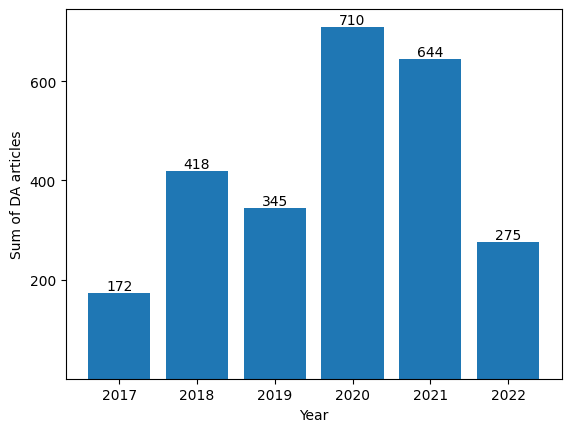

In [240]:
# Plot frequencies 

# Turn to pandas df for plot and focus on years 
df_years = pd.DataFrame.from_dict(factiva_corpus, orient='columns')
df_years['date'] = pd.DatetimeIndex(df_years['date']).year
plot_years = df_years.groupby(['date'])['title'].count()

# Plot as bar chart 
fig, ax = plt.subplots()

# Plot legend
bars = ax.bar(plot_years.index, plot_years)
ax.bar_label(bars)
ax.set_xlabel('Year')
ax.set_ylabel('Sum of DA articles')

# Plot design
ax.set_xticks(plot_years.index)
ax.set_yticks(range(200, 800, 200))

plt.show()

In [253]:
# Preprocess documents for every year 2017 - 2022

# Turn to Language object
factiva_spacy_2017 = []
for doc in tqdm(factiva_2017):
    factiva_spacy_2017.append(spacy_mod(doc['body']))
factiva_spacy_2018 = []
for doc in tqdm(factiva_2018):
    factiva_spacy_2018.append(spacy_mod(doc['body']))
factiva_spacy_2019 = []
for doc in tqdm(factiva_2019):
    factiva_spacy_2019.append(spacy_mod(doc['body']))
factiva_spacy_2020 = []
for doc in tqdm(factiva_2020):
    factiva_spacy_2020.append(spacy_mod(doc['body']))
factiva_spacy_2021 = []
for doc in tqdm(factiva_2021):
    factiva_spacy_2021.append(spacy_mod(doc['body']))
factiva_spacy_2022 = []
for doc in tqdm(factiva_2022):
    factiva_spacy_2022.append(spacy_mod(doc['body']))

# Preprocess corpus
factiva_cleaned_2017 = []
for doc in tqdm(factiva_spacy_2017): 
    factiva_cleaned_2017.append(preprocess(doc, remove_ent=True))
factiva_cleaned_2018 = []
for doc in tqdm(factiva_spacy_2018): 
    factiva_cleaned_2018.append(preprocess(doc, remove_ent=True))
factiva_cleaned_2019 = []
for doc in tqdm(factiva_spacy_2019): 
    factiva_cleaned_2019.append(preprocess(doc, remove_ent=True))
factiva_cleaned_2020 = []
for doc in tqdm(factiva_spacy_2020): 
    factiva_cleaned_2020.append(preprocess(doc, remove_ent=True))
factiva_cleaned_2021 = []
for doc in tqdm(factiva_spacy_2021): 
    factiva_cleaned_2021.append(preprocess(doc, remove_ent=True))
factiva_cleaned_2022 = []
for doc in tqdm(factiva_spacy_2022): 
    factiva_cleaned_2022.append(preprocess(doc, remove_ent=True))

100%|██████████| 275/275 [00:00<00:00, 2499.80it/s]


In [251]:
def collocation_docs(doc:list, filename:str="", filename_top100:str=""):
    """_summary_

    Args:
        doc (list): Nested list of strings 
        filename (str, optional): Filename for list of bigrams. Defaults to "" for no export.
        filename_top100 (str, optional): Filename for list of top 100 bigrams by PMI. Defaults to "" for no export.

    Returns:
        doc_filtered_bigrams (dict): Dictionary of bigrams and scores.
    """
    
    # Create collocations
    finder = nltk.collocations.BigramCollocationFinder.from_documents(doc)
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    doc_bigrams = dict(finder.score_ngrams(bigram_measures.raw_freq))

    # Return as dict
    doc_filtered_bigrams = dict(sorted(doc_bigrams.items(),
                                       key=lambda item: item[1],
                                       reverse=True))

    # If file name given, write information to file in outputs folder
    if not filename:
        pass
    else:
        pp = pprint.PrettyPrinter(indent=2, stream=open(
            str("outputs/"+filename+".txt"), 'w'),
            sort_dicts=False)
        pp.pprint(doc_filtered_bigrams)
    
    # If file name given, write top 100 bigrams by PMI to file in outputs folder
    if not filename_top100:
        pass
    else:
        finder.apply_freq_filter(3)
        with open(str("outputs/"+filename_top100), 'w', encoding='utf-8') as f:
            for item in list(finder.nbest(bigram_measures.pmi, 100)):
                f.write(f'{item}\n')

        return doc_filtered_bigrams


In [254]:
# Bigram collocation analysis for every year

collocation_docs(factiva_cleaned_2017, "factiva_2017", "factive_2017_top100")
collocation_docs(factiva_cleaned_2018, "factiva_2018", "factive_2018_top100")
collocation_docs(factiva_cleaned_2019, "factiva_2019", "factive_2019_top100")
collocation_docs(factiva_cleaned_2020, "factiva_2020", "factive_2020_top100")
collocation_docs(factiva_cleaned_2021, "factiva_2021", "factive_2021_top100")
collocation_docs(factiva_cleaned_2022, "factiva_2022", "factive_2022_top100")

{('häuslicher', 'gewalt'): 0.006715643378986141,
 ('häusliche', 'gewalt'): 0.0038665825515374753,
 ('gewalt', 'frauen'): 0.0019536417102505137,
 ('opfer', 'häuslicher'): 0.0016890860619874235,
 ('frauen', 'kinder'): 0.0010582225930523617,
 ('millionen', 'dollar'): 0.0008547182482345998,
 ('häuslichen', 'gewalt'): 0.0007529660758257188,
 ('millionen', 'euro'): 0.0006105130344532856,
 ('fälle', 'häuslicher'): 0.0005698121654897332,
 ('frauen', 'mädchen'): 0.000549461731007957,
 ('prozent', 'fälle'): 0.0005291112965261809,
 ('sexualisierter', 'gewalt'): 0.0004884104275626284,
 ('opfer', 'gewalt'): 0.0004477095585990761,
 ('sexualisierte', 'gewalt'): 0.0004477095585990761,
 ('fall', 'häuslicher'): 0.0004070086896355237,
 ('kinder', 'jugendliche'): 0.0004070086896355237,
 ('gewalt', 'betroffen'): 0.00038665825515374753,
 ('psychischer', 'gewalt'): 0.00034595738619019515,
 ('sexueller', 'gewalt'): 0.00034595738619019515,
 ('frauen', 'helfen'): 0.000325606951708419,
 ('hilfe', 'suchen'): 0.00

#### Calculate scores for comparison

- raw frequencies 
- PMI 
- chisquare 

In [ ]:
# END OF CODE